In [5]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
#Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz
import xgboost as xgb
from xgboost import XGBRegressor
import time
import pickle

# run pickle

In [6]:
loaded_model = pickle.load(open('final_XGboost_model.pkl', 'rb'))
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [7]:

# read in the cleaned csv

df = pd.read_csv('train_data_2.2.1_change_month.csv')

df

,taxi_zone,datetime,passenger_count,month,week,hour,borough,entertainment_and_recreation,financial_services,food_and_beverage,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday
0,1,2022-01-01 00:00:00,0,1,5,0,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
1,1,2022-01-01 01:00:00,0,1,5,1,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
2,1,2022-01-01 02:00:00,2,1,5,2,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
3,1,2022-01-01 03:00:00,1,1,5,3,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
4,1,2022-01-01 04:00:00,8,1,5,4,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,263,2023-04-30 19:00:00,247,4,6,19,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No
3038036,263,2023-04-30 20:00:00,242,4,6,20,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No
3038037,263,2023-04-30 21:00:00,210,4,6,21,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No
3038038,263,2023-04-30 22:00:00,152,4,6,22,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No


In [8]:
# Create a copy
predict_df = df.copy()
predict_df.dtypes

taxi_zone                           int64
datetime                           object
passenger_count                     int64
month                               int64
week                                int64
hour                                int64
borough                            object
entertainment_and_recreation        int64
financial_services                  int64
food_and_beverage                   int64
parking_and_automotive_services     int64
professional_services               int64
real_estate                         int64
retail_services                     int64
transportation                      int64
hospital                            int64
hotspots                            int64
school                              int64
total_business                      int64
holiday                            object
dtype: object

In [9]:
predict_df['taxi_zone'] = predict_df['taxi_zone'].astype('category')
predict_df['month'] = predict_df['month'].astype('category')
predict_df['week'] = predict_df['week'].astype('category')
predict_df['hour'] = predict_df['hour'].astype('category')
predict_df['holiday'] = predict_df['holiday'].astype('category')
predict_df.dtypes

taxi_zone                          category
datetime                             object
passenger_count                       int64
month                              category
week                               category
hour                               category
borough                              object
entertainment_and_recreation          int64
financial_services                    int64
food_and_beverage                     int64
parking_and_automotive_services       int64
professional_services                 int64
real_estate                           int64
retail_services                       int64
transportation                        int64
hospital                              int64
hotspots                              int64
school                                int64
total_business                        int64
holiday                            category
dtype: object

In [10]:
# Convert the 'datetime' column to datetime format
predict_df['datetime'] = pd.to_datetime(predict_df['datetime'])

# Filter rows based on year and month
# df_2023_jan_feb = predict_df[(predict_df['datetime'].dt.year == 2023) & (predict_df['datetime'].dt.month.isin([1, 2]))]
# df_2023_jan_feb

In [11]:
predict_df = predict_df.drop('datetime', axis=1)
predict_df

,taxi_zone,passenger_count,month,week,hour,borough,entertainment_and_recreation,financial_services,food_and_beverage,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday
0,1,0,1,5,0,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
1,1,0,1,5,1,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
2,1,2,1,5,2,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
3,1,1,1,5,3,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
4,1,8,1,5,4,EWR,0,0,0,0,0,0,0,0,0,0,0,0,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,263,247,4,6,19,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No
3038036,263,242,4,6,20,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No
3038037,263,210,4,6,21,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No
3038038,263,152,4,6,22,Manhattan,69,0,0,37,11,116,108,4,0,14,4,363,No


In [12]:
# set up dummies features
predict_df = pd.get_dummies(predict_df)
predict_df.dtypes

passenger_count                      int64
entertainment_and_recreation         int64
financial_services                   int64
food_and_beverage                    int64
parking_and_automotive_services      int64
                                     ...  
holiday_New Year's Day (Observed)    uint8
holiday_No                           uint8
holiday_Thanksgiving                 uint8
holiday_Veterans Day                 uint8
holiday_Washington's Birthday        uint8
Length: 336, dtype: object

In [13]:
# split data set into the features and target feature
target_feature = pd.DataFrame(predict_df["passenger_count"])
features = predict_df.drop(labels=["passenger_count"], axis=1)
features

,entertainment_and_recreation,financial_services,food_and_beverage,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,...,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr. Day,holiday_Memorial Day,holiday_New Year's Day,holiday_New Year's Day (Observed),holiday_No,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0
3038036,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0
3038037,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0
3038038,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0


In [14]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
target_feature.reset_index(drop=True, inplace=True)
features.reset_index(drop=True, inplace=True)
features

,entertainment_and_recreation,financial_services,food_and_beverage,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,...,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr. Day,holiday_Memorial Day,holiday_New Year's Day,holiday_New Year's Day (Observed),holiday_No,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0
3038036,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0
3038037,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0
3038038,69,0,0,37,11,116,108,4,0,14,...,0,0,0,0,0,0,1,0,0,0


In [15]:
# make predict
predictions = loaded_model.predict(features)

predictions[predictions < 0] = 0
# print predictions
print(predictions)

[  7.083603    5.200867    7.2553196 ... 301.56372   174.11325
 118.513725 ]


In [16]:
# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['predicted_passenger_count'])

# Reset indices of target_feature, features DataFrames to align with predictions_df
target_feature.reset_index(drop=True, inplace=True)
features.reset_index(drop=True, inplace=True)

# Concatenate the target_feature, features and predictions dataframes
result = pd.concat([predictions_df, target_feature, features], axis=1)

result


,predicted_passenger_count,passenger_count,entertainment_and_recreation,financial_services,food_and_beverage,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,...,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr. Day,holiday_Memorial Day,holiday_New Year's Day,holiday_New Year's Day (Observed),holiday_No,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday
0,7.083603,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5.200867,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,7.255320,2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7.560405,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,13.775771,8,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,334.164124,247,69,0,0,37,11,116,108,4,...,0,0,0,0,0,0,1,0,0,0
3038036,286.001373,242,69,0,0,37,11,116,108,4,...,0,0,0,0,0,0,1,0,0,0
3038037,301.563721,210,69,0,0,37,11,116,108,4,...,0,0,0,0,0,0,1,0,0,0
3038038,174.113251,152,69,0,0,37,11,116,108,4,...,0,0,0,0,0,0,1,0,0,0


In [17]:
smallest_value = result['predicted_passenger_count'].min()
largest_value = result['predicted_passenger_count'].max()

print(f"The smallest value in the feature is: {smallest_value}")
print(f"The largest value in the feature is: {largest_value}")


The smallest value in the feature is: 0.0
The largest value in the feature is: 1625.2015380859375


In [18]:
# Calculate MAE, MSE and RMSE
mae = metrics.mean_absolute_error(result['passenger_count'], result['predicted_passenger_count'])
mse = metrics.mean_squared_error(result['passenger_count'], result['predicted_passenger_count'])
rmse = np.sqrt(mse) # or mse**(0.5)  

# Calculate MAPE
epsilon = 1  # Small constant to avoid division by zero
mape = np.mean(np.abs((result['passenger_count'] - result['predicted_passenger_count']) / (result['passenger_count'] + epsilon))) * 100

# Calculate the arctangent absolute percentage error for each observation
atans = np.arctan(np.abs(((result['passenger_count'] + epsilon) - (result['predicted_passenger_count']+ epsilon)) / (result['passenger_count'] + 1e-6)))
# Calculate the mean arctangent absolute percentage error
maape = np.mean(atans) * 100

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape, '%')
print('Mean Arctangent Absolute Percentage Error (MAAPE):', maape, '%')

# Calculate the numerator and denominator separately
numerator = np.abs(result['passenger_count'] - result['predicted_passenger_count'])
denominator = (np.abs(result['passenger_count']) + np.abs(result['predicted_passenger_count'])) / 2

# Use a small constant in the denominator to avoid division by zero
epsilon = 1e-6

# Calculate sMAPE
smape = np.mean(numerator / (denominator + epsilon)) * 100

print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape, '%')

Mean Absolute Error (MAE): 6.609400785933017
Mean Squared Error (MSE): 376.02072462793564
Root Mean Squared Error (RMSE): 19.391253817841065
Mean Absolute Percentage Error (MAPE): 49.34508752539635 %
Mean Arctangent Absolute Percentage Error (MAAPE): 66.35849668602935 %
Symmetric Mean Absolute Percentage Error (sMAPE): 82.80546920088526 %


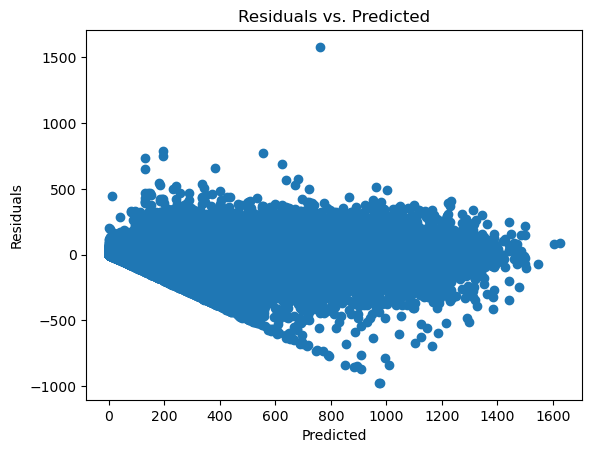

In [33]:
# Calculate residuals
residuals = result['passenger_count'] - result['predicted_passenger_count']

# Plot residuals
plt.scatter(result['predicted_passenger_count'], residuals)  # <-- This line has been corrected
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()


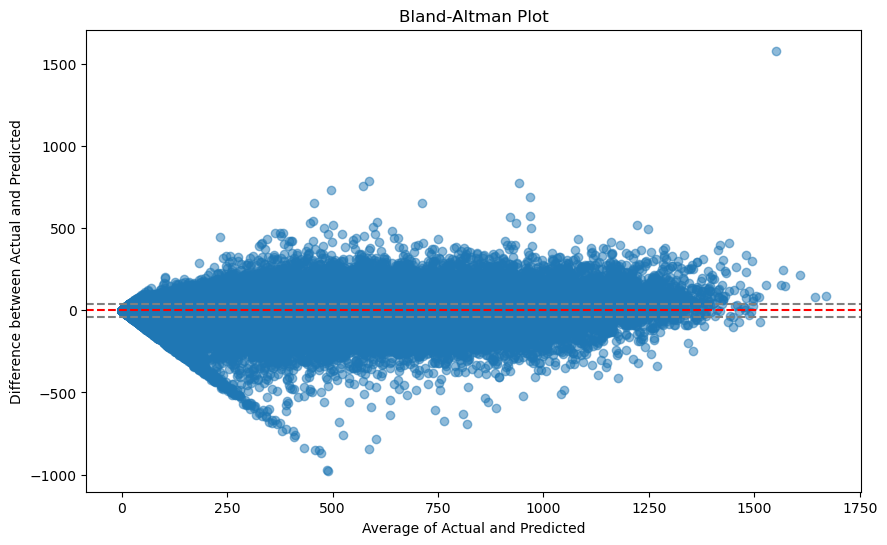

In [114]:
import matplotlib.pyplot as plt

# Compute differences and average
result['difference'] = result['passenger_count'] - result['predicted_passenger_count']
result['average'] = (result['passenger_count'] + result['predicted_passenger_count']) / 2

# Compute mean and standard deviation of the differences
mean_diff = result['difference'].mean()
std_diff = result['difference'].std()

# Create Bland-Altman plot
plt.figure(figsize=(10, 6))
plt.scatter(result['average'], result['difference'], alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96*std_diff, color='grey', linestyle='--')
plt.axhline(mean_diff - 1.96*std_diff, color='grey', linestyle='--')

# Add titles and labels
plt.title('Bland-Altman Plot')
plt.xlabel('Average of Actual and Predicted')
plt.ylabel('Difference between Actual and Predicted')
plt.show()


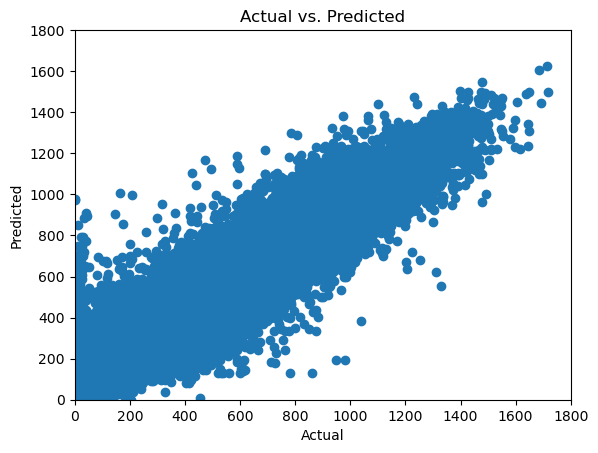

In [28]:
plt.scatter(result['passenger_count'], result['predicted_passenger_count'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.xlim(0, 1800)  
plt.ylim(0, 1800)  
plt.show()


# A perfect predictor would result in all points lying on a diagonal line.

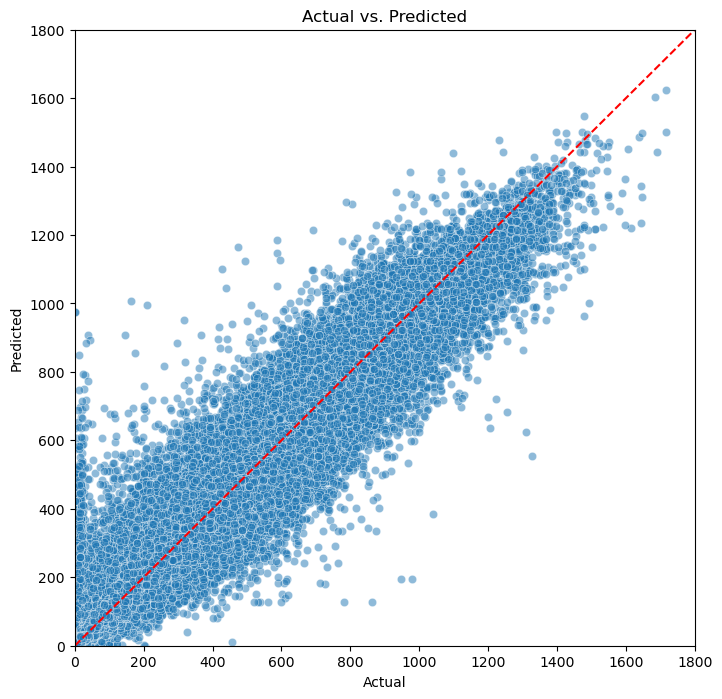

In [109]:

# Create a scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x='passenger_count', y='predicted_passenger_count', data=result, alpha=0.5)

# Plotting the diagonal line for perfect predictions
max_value = max(result['predicted_passenger_count'].max(), result['passenger_count'].max())
plt.plot([0, max_value + 1], [0, max_value + 1], color='red', linestyle='--')

# Setting axis limits
plt.xlim(0, 1800)
plt.ylim(0, 1800)

# Setting title and labels 

plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


In [24]:

# Reset indices of target_feature, features DataFrames to align with predictions_df
df.reset_index(drop=True, inplace=True)

# Concatenate the target_feature, features and predictions dataframes
result_conbine_original = pd.concat([predictions_df, df], axis=1)

result_conbine_original

,predicted_passenger_count,taxi_zone,datetime,passenger_count,month,week,hour,borough,entertainment_and_recreation,financial_services,...,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday
0,7.083603,1,2022-01-01 00:00:00,0,1,5,0,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
1,5.200867,1,2022-01-01 01:00:00,0,1,5,1,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
2,7.255320,1,2022-01-01 02:00:00,2,1,5,2,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
3,7.560405,1,2022-01-01 03:00:00,1,1,5,3,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
4,13.775771,1,2022-01-01 04:00:00,8,1,5,4,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,334.164124,263,2023-04-30 19:00:00,247,4,6,19,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038036,286.001373,263,2023-04-30 20:00:00,242,4,6,20,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038037,301.563721,263,2023-04-30 21:00:00,210,4,6,21,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038038,174.113251,263,2023-04-30 22:00:00,152,4,6,22,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No


In [31]:
result_conbine_original

,predicted_passenger_count,taxi_zone,datetime,passenger_count,month,week,hour,borough,entertainment_and_recreation,financial_services,...,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday
0,7.083603,1,2022-01-01 00:00:00,0,1,5,0,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
1,5.200867,1,2022-01-01 01:00:00,0,1,5,1,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
2,7.255320,1,2022-01-01 02:00:00,2,1,5,2,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
3,7.560405,1,2022-01-01 03:00:00,1,1,5,3,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
4,13.775771,1,2022-01-01 04:00:00,8,1,5,4,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,334.164124,263,2023-04-30 19:00:00,247,4,6,19,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038036,286.001373,263,2023-04-30 20:00:00,242,4,6,20,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038037,301.563721,263,2023-04-30 21:00:00,210,4,6,21,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038038,174.113251,263,2023-04-30 22:00:00,152,4,6,22,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No


In [32]:
# Check if 'predicted_passenger_count' in both dataframes are the same
predicted_check = result_conbine_original['predicted_passenger_count'].equals(result['predicted_passenger_count'])

# Check if 'passenger_count' in both dataframes are the same
passenger_check = result_conbine_original['passenger_count'].equals(result['passenger_count'])

# Print the results
if predicted_check and passenger_check:
    print("Both columns in the two datasets match perfectly.")
elif predicted_check:
    print("'predicted_passenger_count' columns match, but 'passenger_count' columns do not.")
elif passenger_check:
    print("'passenger_count' columns match, but 'predicted_passenger_count' columns do not.")
else:
    print("Neither columns in the two datasets match.")


Both columns in the two datasets match perfectly.


In [50]:
cols_to_avg = ['taxi_zone', 'hour', 'predicted_passenger_count', 'passenger_count', 'entertainment_and_recreation', 
               'financial_services', 'food_and_beverage', 'parking_and_automotive_services', 
               'professional_services', 'real_estate', 'retail_services', 'transportation', 
               'hospital', 'hotspots', 'school',
               'total_business']

grouped_taxi_hour = result_conbine_original[cols_to_avg].groupby(['taxi_zone', 'hour']).mean().reset_index()
grouped_taxi_hour

,taxi_zone,hour,predicted_passenger_count,passenger_count,entertainment_and_recreation,financial_services,food_and_beverage,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business
0,1,0,2.888742,1.088660,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,1,1,2.805539,0.956701,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,1,2,2.343266,1.059794,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,1,3,4.783358,3.340206,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,1,4,11.617765,10.084536,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6259,263,19,432.668091,432.684536,67.4,0.814433,0.931959,37.715464,11.0,115.492784,108.542268,4.439175,0.0,14.0,4.0,364.336082
6260,263,20,389.440521,388.872165,67.4,0.814433,0.931959,37.715464,11.0,115.492784,108.542268,4.439175,0.0,14.0,4.0,364.336082
6261,263,21,377.909363,379.115464,67.4,0.814433,0.931959,37.715464,11.0,115.492784,108.542268,4.439175,0.0,14.0,4.0,364.336082
6262,263,22,364.256531,363.779381,67.4,0.814433,0.931959,37.715464,11.0,115.492784,108.542268,4.439175,0.0,14.0,4.0,364.336082


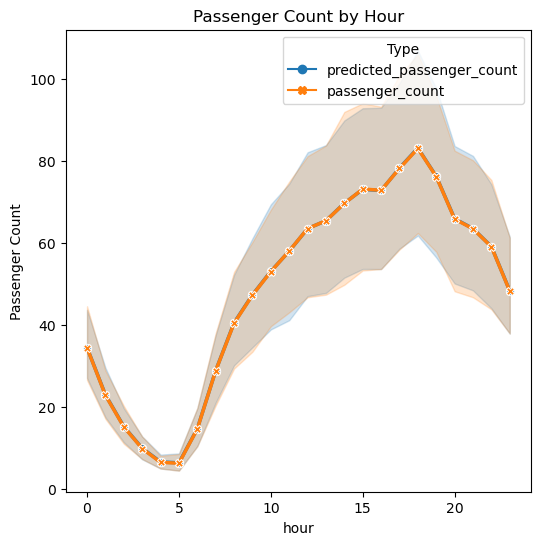

In [52]:
# Melt the dataframe for seaborn plotting
df_melted = grouped_taxi_hour.melt(id_vars='hour', value_vars=['predicted_passenger_count', 'passenger_count'], 
                                   var_name='Type', value_name='Passenger Count')
plt.figure(figsize=(6, 6))

# Create the line plot with style, markers, and line width options
sns.lineplot(data=df_melted, x='hour', y='Passenger Count', hue='Type', 
             style='Type', markers=True, dashes=False, linewidth=2.5)

plt.title('Passenger Count by Hour')
plt.show()


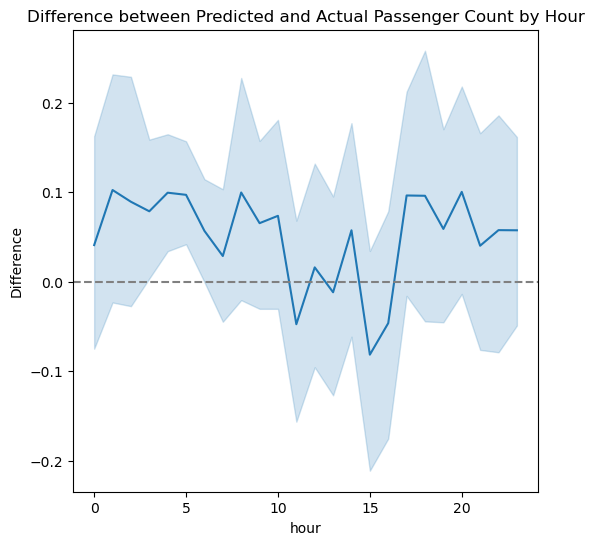

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the difference
grouped_taxi_hour['difference'] = grouped_taxi_hour['predicted_passenger_count'] - grouped_taxi_hour['passenger_count']

# Plot the difference
plt.figure(figsize=(6, 6))
sns.lineplot(data=grouped_taxi_hour, x='hour', y='difference')
plt.axhline(0, color='grey', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Difference between Predicted and Actual Passenger Count by Hour')
plt.ylabel('Difference')
plt.show()


In [53]:
result_conbine_original

,predicted_passenger_count,taxi_zone,datetime,passenger_count,month,week,hour,borough,entertainment_and_recreation,financial_services,...,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday
0,7.083603,1,2022-01-01 00:00:00,0,1,5,0,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
1,5.200867,1,2022-01-01 01:00:00,0,1,5,1,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
2,7.255320,1,2022-01-01 02:00:00,2,1,5,2,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
3,7.560405,1,2022-01-01 03:00:00,1,1,5,3,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
4,13.775771,1,2022-01-01 04:00:00,8,1,5,4,EWR,0,0,...,0,0,0,0,0,0,0,0,0,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,334.164124,263,2023-04-30 19:00:00,247,4,6,19,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038036,286.001373,263,2023-04-30 20:00:00,242,4,6,20,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038037,301.563721,263,2023-04-30 21:00:00,210,4,6,21,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No
3038038,174.113251,263,2023-04-30 22:00:00,152,4,6,22,Manhattan,69,0,...,37,11,116,108,4,0,14,4,363,No


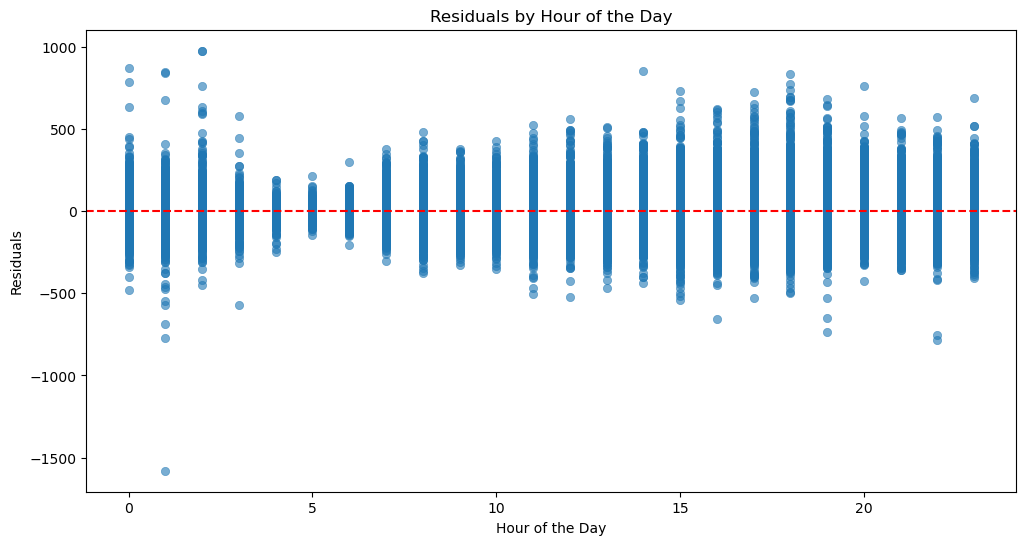

In [54]:


# Calculate the residuals
result_conbine_original['residuals'] = result_conbine_original['predicted_passenger_count'] - result_conbine_original['passenger_count']

plt.figure(figsize=(12, 6))

# Scatter plot residuals by hour
sns.scatterplot(data=result_conbine_original, x='hour', y='residuals', alpha=0.6, edgecolor=None)

plt.axhline(0, color='red', linestyle='--')  # To add a reference line at 0 residual
plt.title('Residuals by Hour of the Day')
plt.ylabel('Residuals')
plt.xlabel('Hour of the Day')

plt.show()


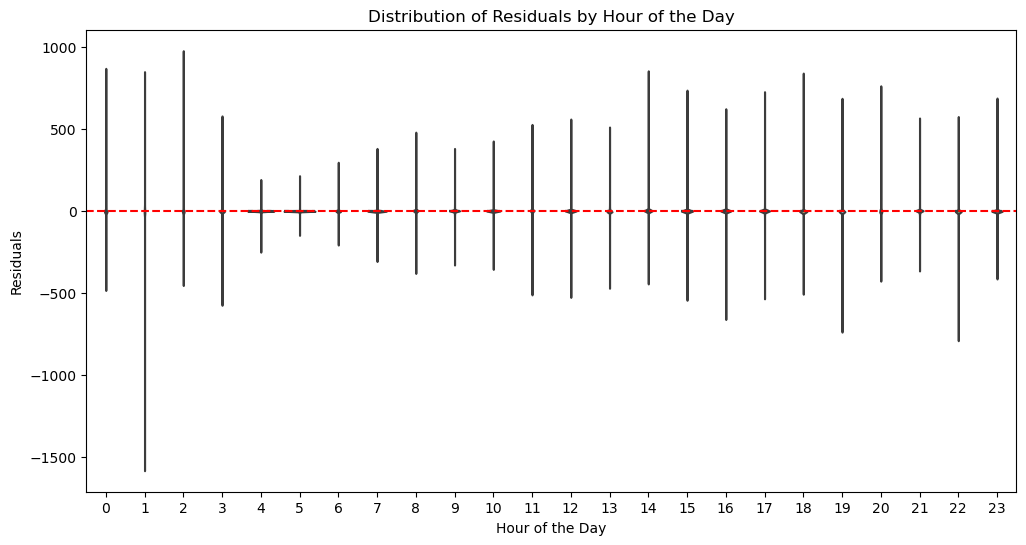

In [55]:


# Calculate the residuals
result_conbine_original['residuals'] = result_conbine_original['predicted_passenger_count'] - result_conbine_original['passenger_count']

plt.figure(figsize=(12, 6))

# Create violin plot of residuals by hour
sns.violinplot(data=result_conbine_original, x='hour', y='residuals', inner="quartile", palette="muted")

plt.axhline(0, color='red', linestyle='--')  # To add a reference line at 0 residual
plt.title('Distribution of Residuals by Hour of the Day')
plt.ylabel('Residuals')
plt.xlabel('Hour of the Day')

plt.show()


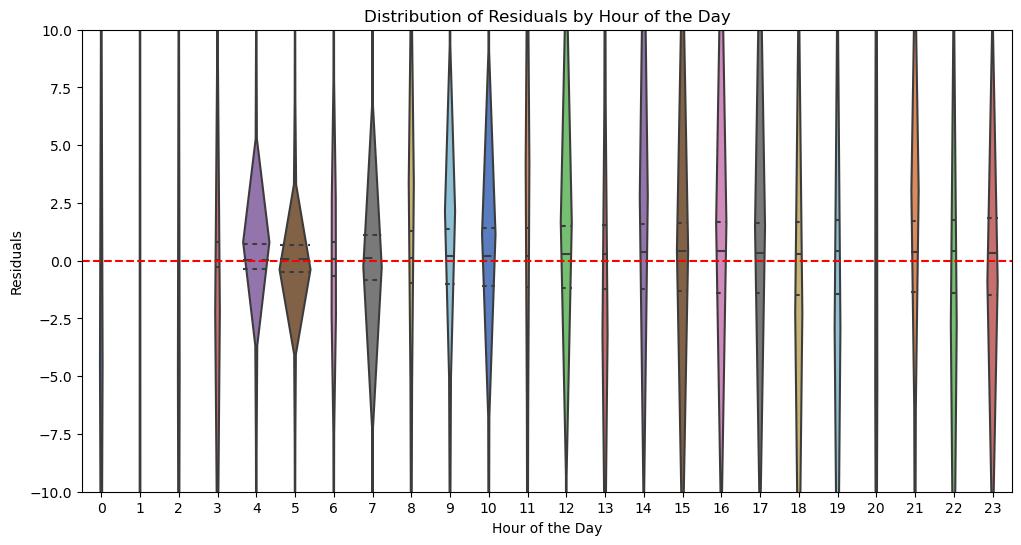

In [56]:
plt.figure(figsize=(12, 6))

# Create violin plot of residuals by hour
sns.violinplot(data=result_conbine_original, x='hour', y='residuals', inner="quartile", palette="muted")

plt.axhline(0, color='red', linestyle='--')  # Add a reference line at 0 residual
plt.title('Distribution of Residuals by Hour of the Day')
plt.ylabel('Residuals')
plt.xlabel('Hour of the Day')

# Let's limit the y-axis to observe the range -10 to 10, for example:
plt.ylim(-10, 10)

plt.show()


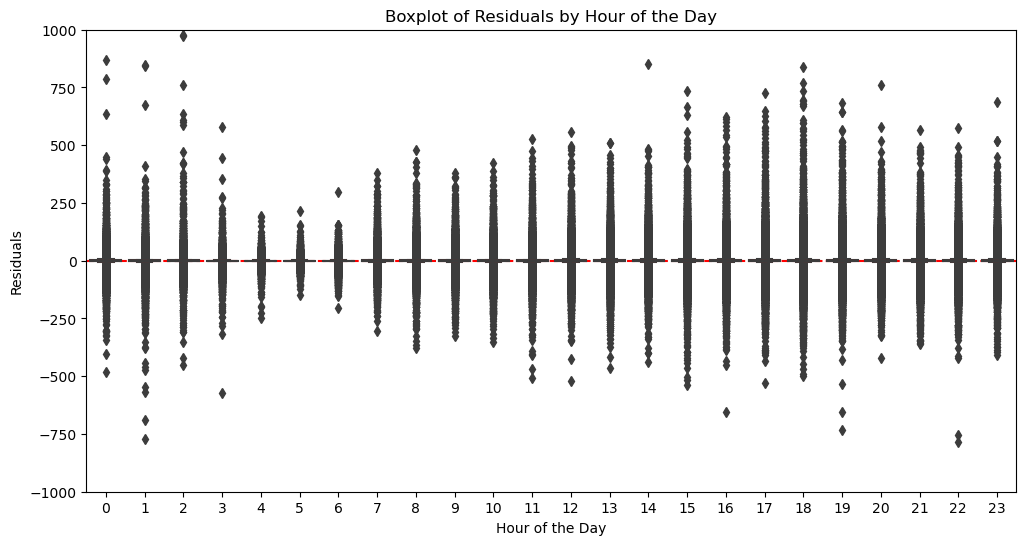

In [87]:
plt.figure(figsize=(12, 6))

# Create boxplot of residuals by hour
sns.boxplot(data=result_conbine_original, x='hour', y='residuals', palette="muted")

plt.axhline(0, color='red', linestyle='--')  # Add a reference line at 0 residual
plt.title('Boxplot of Residuals by Hour of the Day')
plt.ylabel('Residuals')
plt.xlabel('Hour of the Day')
plt.ylim(-1000, 1000)
plt.show()


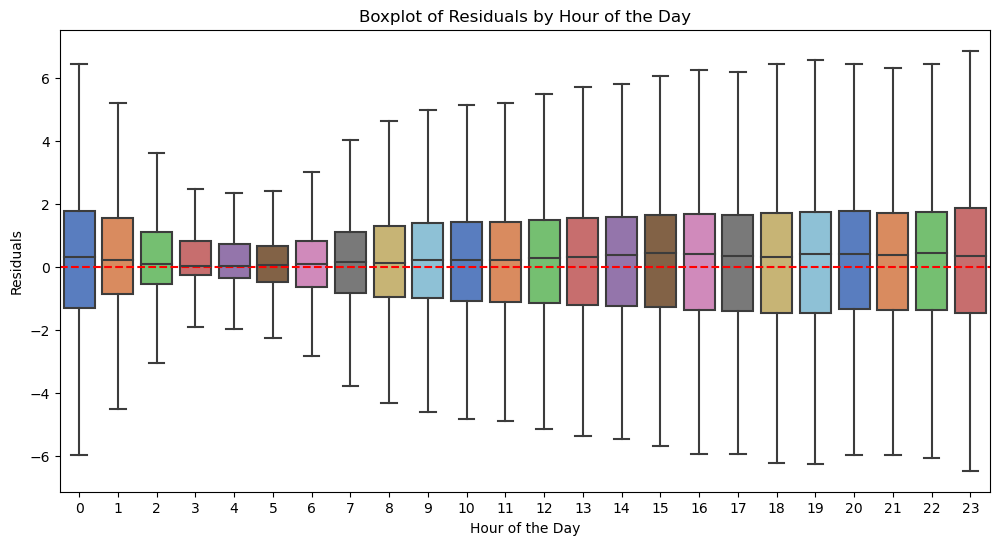

In [61]:
# Calculate the residuals
result_conbine_original['residuals'] = result_conbine_original['predicted_passenger_count'] - result_conbine_original['passenger_count']

plt.figure(figsize=(12, 6))

# Create boxplot of residuals by hour without outliers
sns.boxplot(data=result_conbine_original, x='hour', y='residuals', palette="muted", showfliers=False)

plt.axhline(0, color='red', linestyle='--')  # Add a reference line at 0 residual
plt.title('Boxplot of Residuals by Hour of the Day')
plt.ylabel('Residuals')
plt.xlabel('Hour of the Day')

plt.show()


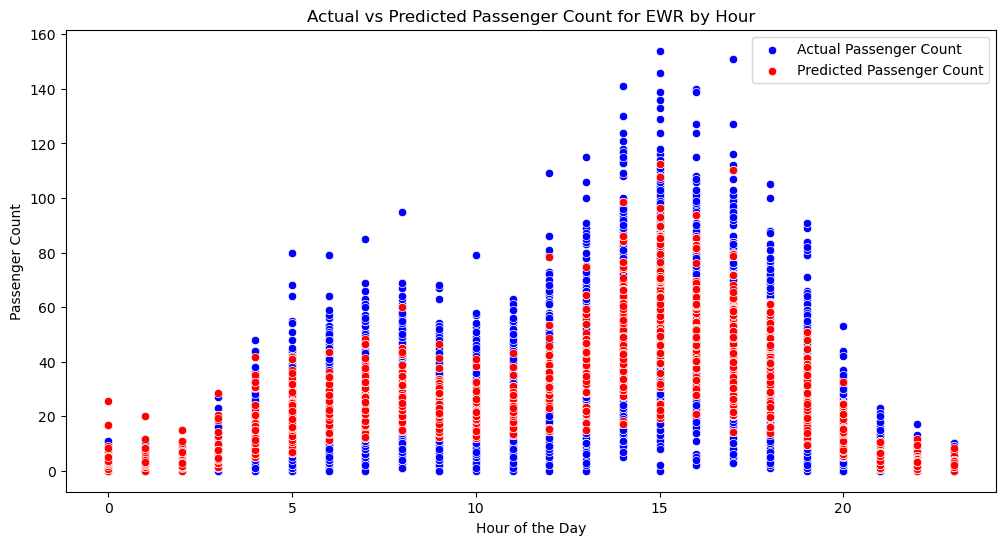

In [63]:
# Filter data for borough 'EWR'
ewr_data = result_conbine_original[result_conbine_original['borough'] == 'EWR']

plt.figure(figsize=(12, 6))

# Plot the actual passenger counts
sns.scatterplot(data=ewr_data, x='hour', y='passenger_count', color='blue', label='Actual Passenger Count')

# Plot the predicted passenger counts
sns.scatterplot(data=ewr_data, x='hour', y='predicted_passenger_count', color='red', label='Predicted Passenger Count')

# Add title and labels
plt.title('Actual vs Predicted Passenger Count for EWR by Hour')
plt.ylabel('Passenger Count')
plt.xlabel('Hour of the Day')
plt.legend()

plt.show()


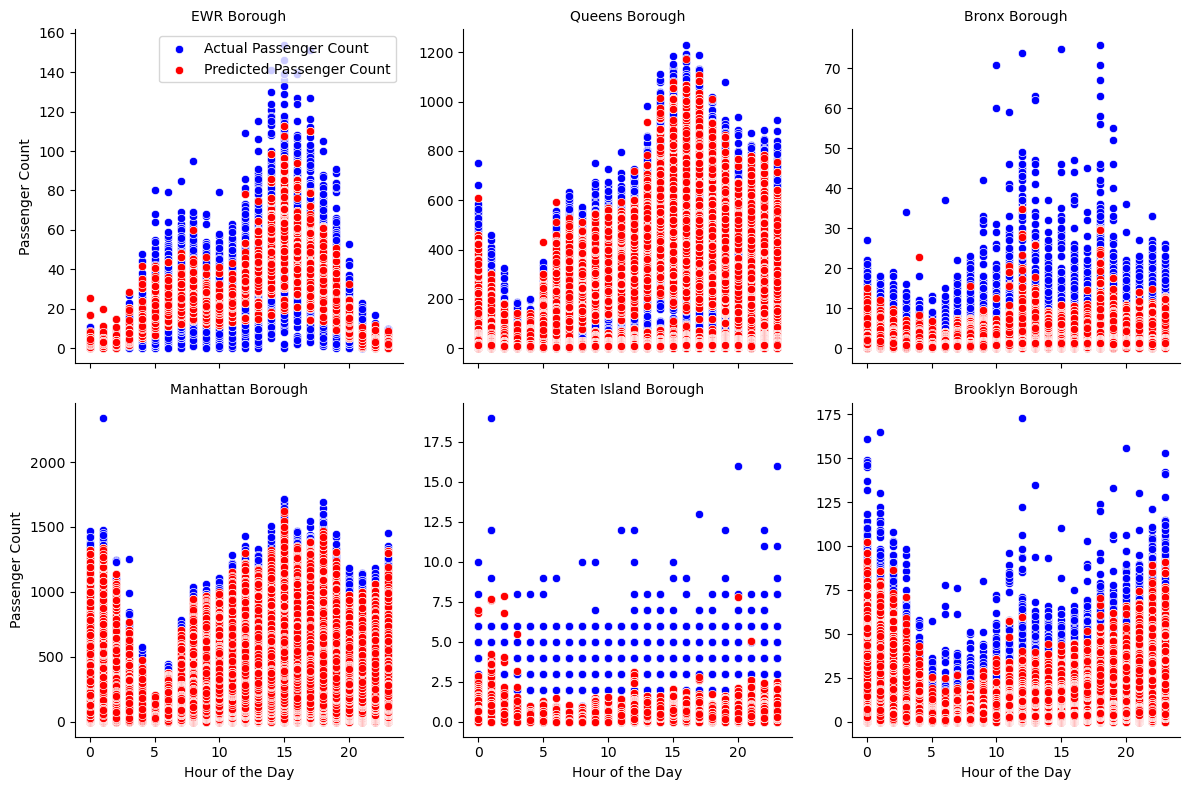

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a FacetGrid object with 'borough' as the facet and define the size and aspect
g = sns.FacetGrid(result_conbine_original, col='borough', col_wrap=3, height=4, aspect=1, sharey=False)

# Map the scatter plots to the grid
g.map(sns.scatterplot, 'hour', 'passenger_count', color='blue', label='Actual Passenger Count')
g.map(sns.scatterplot, 'hour', 'predicted_passenger_count', color='red', label='Predicted Passenger Count')

# Add titles and labels
g.set_axis_labels('Hour of the Day', 'Passenger Count')
g.set_titles('{col_name} Borough')

# Add a legend to the first plot for clarity
g.axes[0].legend(loc='upper right')

# Adjust layout for better visualization
g.tight_layout()

plt.show()


In [70]:
result_conbine_original

,predicted_passenger_count,taxi_zone,datetime,passenger_count,month,week,hour,borough,entertainment_and_recreation,financial_services,...,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday,residuals
0,7.083603,1,2022-01-01 00:00:00,0,1,5,0,EWR,0,0,...,0,0,0,0,0,0,0,0,New Year's Day,7.083603
1,5.200867,1,2022-01-01 01:00:00,0,1,5,1,EWR,0,0,...,0,0,0,0,0,0,0,0,New Year's Day,5.200867
2,7.255320,1,2022-01-01 02:00:00,2,1,5,2,EWR,0,0,...,0,0,0,0,0,0,0,0,New Year's Day,5.255320
3,7.560405,1,2022-01-01 03:00:00,1,1,5,3,EWR,0,0,...,0,0,0,0,0,0,0,0,New Year's Day,6.560405
4,13.775771,1,2022-01-01 04:00:00,8,1,5,4,EWR,0,0,...,0,0,0,0,0,0,0,0,New Year's Day,5.775771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038035,334.164124,263,2023-04-30 19:00:00,247,4,6,19,Manhattan,69,0,...,11,116,108,4,0,14,4,363,No,87.164124
3038036,286.001373,263,2023-04-30 20:00:00,242,4,6,20,Manhattan,69,0,...,11,116,108,4,0,14,4,363,No,44.001373
3038037,301.563721,263,2023-04-30 21:00:00,210,4,6,21,Manhattan,69,0,...,11,116,108,4,0,14,4,363,No,91.563721
3038038,174.113251,263,2023-04-30 22:00:00,152,4,6,22,Manhattan,69,0,...,11,116,108,4,0,14,4,363,No,22.113251


In [105]:
# Convert 'datetime' to datetime format if it's not already
result_conbine_original['datetime'] = pd.to_datetime(result_conbine_original['datetime'])

# Create a new column 'date' by stripping hour information from 'datetime'
result_conbine_original['date'] = result_conbine_original['datetime'].dt.date

# Group by 'taxi_zone' and 'date', summing 'passenger_count', and average values for other columns
grouped_day = result_conbine_original.groupby(['taxi_zone', 'date']).agg({
    'predicted_passenger_count': 'sum',
    'passenger_count': 'sum',
    'month': 'first',  # assuming this is non-numeric and we just need the first value
    'week': 'first',
    'borough': 'first',
    'entertainment_and_recreation': 'mean',
    'financial_services': 'mean',
    'food_and_beverage': 'mean',
    'parking_and_automotive_services': 'mean',
    'professional_services': 'mean',
    'real_estate': 'mean',
    'retail_services': 'mean',
    'transportation': 'mean',
    'hospital': 'mean',
    'hotspots': 'mean',
    'school': 'mean',
    'total_business': 'mean',
    'holiday': 'first'
}).reset_index()

grouped_day

,taxi_zone,date,predicted_passenger_count,passenger_count,month,week,borough,entertainment_and_recreation,financial_services,food_and_beverage,parking_and_automotive_services,professional_services,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday
0,1,2022-01-01,493.969238,619,1,5,EWR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,New Year's Day
1,1,2022-01-02,434.372620,684,1,6,EWR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No
2,1,2022-01-03,287.939667,508,1,0,EWR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No
3,1,2022-01-04,281.300812,311,1,1,EWR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No
4,1,2022-01-05,274.393890,260,1,2,EWR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126580,263,2023-04-26,5772.115234,5843,4,2,Manhattan,69.0,0.0,0.0,37.0,11.0,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No
126581,263,2023-04-27,5927.673340,5795,4,3,Manhattan,69.0,0.0,0.0,37.0,11.0,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No
126582,263,2023-04-28,6572.578125,7114,4,4,Manhattan,69.0,0.0,0.0,37.0,11.0,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No
126583,263,2023-04-29,7094.145508,7096,4,5,Manhattan,69.0,0.0,0.0,37.0,11.0,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No


In [106]:
# Sorting and ranking predicted_passenger_count
grouped_day['predicted_ranking'] = grouped_day.groupby('date')['predicted_passenger_count'].rank(method='min', ascending=False).astype(int)

# Sorting and ranking passenger_count
grouped_day['actual_ranking'] = grouped_day.groupby('date')['passenger_count'].rank(method='min', ascending=False).astype(int)
grouped_day

,taxi_zone,date,predicted_passenger_count,passenger_count,month,week,borough,entertainment_and_recreation,financial_services,food_and_beverage,...,real_estate,retail_services,transportation,hospital,hotspots,school,total_business,holiday,predicted_ranking,actual_ranking
0,1,2022-01-01,493.969238,619,1,5,EWR,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,New Year's Day,62,58
1,1,2022-01-02,434.372620,684,1,6,EWR,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No,60,52
2,1,2022-01-03,287.939667,508,1,0,EWR,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No,69,60
3,1,2022-01-04,281.300812,311,1,1,EWR,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No,69,67
4,1,2022-01-05,274.393890,260,1,2,EWR,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,No,69,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126580,263,2023-04-26,5772.115234,5843,4,2,Manhattan,69.0,0.0,0.0,...,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No,22,22
126581,263,2023-04-27,5927.673340,5795,4,3,Manhattan,69.0,0.0,0.0,...,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No,23,23
126582,263,2023-04-28,6572.578125,7114,4,4,Manhattan,69.0,0.0,0.0,...,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No,22,20
126583,263,2023-04-29,7094.145508,7096,4,5,Manhattan,69.0,0.0,0.0,...,116.0,108.0,5.000000,0.0,14.0,4.0,364.000000,No,20,19


In [111]:
unique_values = grouped_day['predicted_ranking'].unique()
print(unique_values)


[ 62  60  69  80  68  78  61  67  71  72  58  66  64  65  59  63  57  56
  51  52  50  73  82  83  84 255 254 252 256 259 257 253 246 258 247 245
 244 249 248 251 250 235 237 242 224 223 216 218 221 219 222 217 220 215
 226 201 214 225 227 213 233 234 228 208 211 210 212  53  54  55 229 240
 243 239 232 238 241 236 230 231 209 207 200 202 205 206 204 203 196 194
 199 195 197 187 186 198 172 192 184 152 191 185 153 193 178  89  88  77
  85  86  91  87  90  92  93  95  94  96  76  81 100 104 102 101 105 103
 106 109  98 111 112  99  97 110 108  46  47  45  44  41  42  43  40  39
  48 107 113 189 188 182 183 190 180 181 177 179 159 164 165 167 166 160
 162 156 163 157 173 168 171 174 169 161 154 175 170 150 148 151 158 149
 147 155 176 143 146 145 144 135 138 141 137  49  79  75  70  74 128 127
 124 133 125 122 134 121 116 119 120 130 123 118 129 117 142 131 140 132
 136 139 126 114 115 261 260  28  25  23  27  26  24  33  29  30  22  19
   1   3  13  15  14   5   2  11   7   8   9   6  1

In [112]:
unique_values = grouped_day['actual_ranking'].unique()
print(unique_values)

[ 58  52  60  67  69  71  79  75  84  89  82  78  87  74  77  98  85  83
  88  99  66  80  86  68  73  65  72  61  70  76  63  64  62  56  53  54
  55  59  57  50  49 234 249 245 248 242 236 239 246 244 247 243 227 237
 250 230 241 251 253 229 252 254 255 231 256 233 257 225 235 228 226 240
 232 183 207 220 215 217 221 191 199 184 204 168 219 203 190 218 222 189
 181 216 210 170 180 182 213 209 205 187 192 206 214 202 212 224 197 211
 196 179 223 201 200 175 188 193 194 208 198 186 195 165 178 176 162 185
 155 167  51  44 238 174  20 137 159 161 144 140 150 173 177 157 164 160
 141 171 133 142 143 154 152 163 153 172 169 156 158  97  81  90 103 101
  94  91  95  96  92 100 108 102 114  93 106 166 110 104 105 131 115 112
 116 109 128 127 139 126 120 107 111 113 136 118 125 135 119 129 132 121
  46  43  45  47  48  42  41  40  39  38  37  36 117 122 134 149 151 145
 147 138 146 148 130 123 124   4  19  31  24  23  22  25  29  26  27  28
  33  32  30  34  21  18  17   1   3  10  13   7  1

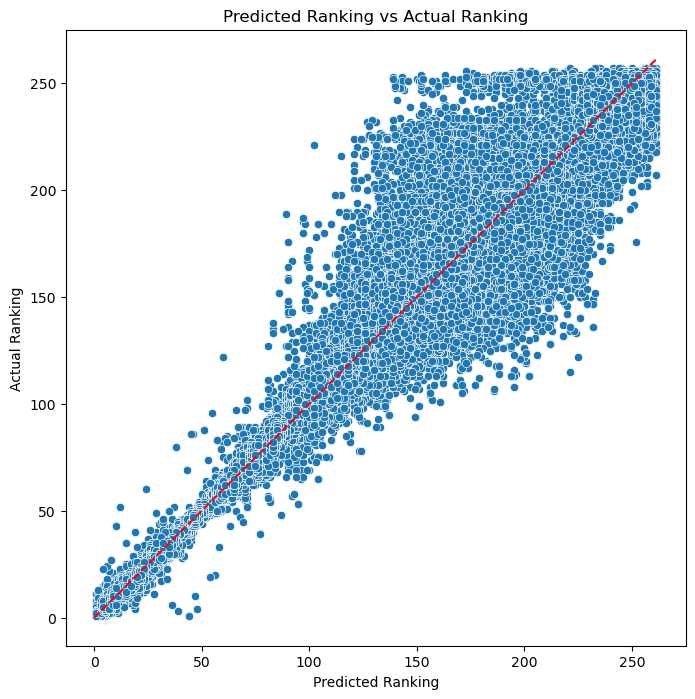

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x='predicted_ranking', y='actual_ranking', data=grouped_day)

# Plotting the diagonal line for perfect predictions
max_rank = max(grouped_day['predicted_ranking'].max(), grouped_day['actual_ranking'].max())
plt.plot([0, max_rank + 1], [0, max_rank + 1], color='red', linestyle='--')

# Setting title and labels
plt.title('Predicted Ranking vs Actual Ranking')
plt.xlabel('Predicted Ranking')
plt.ylabel('Actual Ranking')
plt.show()


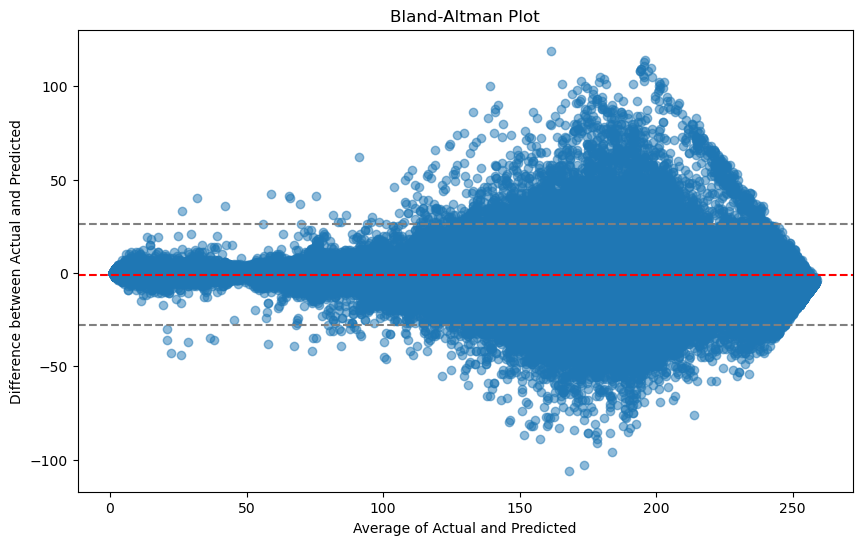

In [113]:
import matplotlib.pyplot as plt

# Compute differences and average
grouped_day['difference'] = grouped_day['actual_ranking'] - grouped_day['predicted_ranking']
grouped_day['average'] = (grouped_day['actual_ranking'] + grouped_day['predicted_ranking']) / 2

# Compute mean and standard deviation of the differences
mean_diff = grouped_day['difference'].mean()
std_diff = grouped_day['difference'].std()

# Create Bland-Altman plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped_day['average'], grouped_day['difference'], alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--')
plt.axhline(mean_diff + 1.96*std_diff, color='grey', linestyle='--')
plt.axhline(mean_diff - 1.96*std_diff, color='grey', linestyle='--')

# Add titles and labels
plt.title('Bland-Altman Plot')
plt.xlabel('Average of Actual and Predicted')
plt.ylabel('Difference between Actual and Predicted')
plt.show()


In [94]:
from scipy.stats import spearmanr
correlation, p_value = spearmanr(grouped_day['predicted_ranking'], grouped_day['actual_ranking'])
print(f"Spearman's Rank Correlation: {correlation:.2f}")

from scipy.stats import kendalltau
tau, p_value = kendalltau(grouped_day['predicted_ranking'], grouped_day['actual_ranking'])
print(f"Kendall’s Tau: {tau:.2f}")

mae = (grouped_day['predicted_ranking'] - grouped_day['actual_ranking']).abs().mean()
print(f"Mean Absolute Error between Rankings: {mae:.2f}")


Spearman's Rank Correlation: 0.98
Kendall’s Tau: 0.91
Mean Absolute Error between Rankings: 8.57


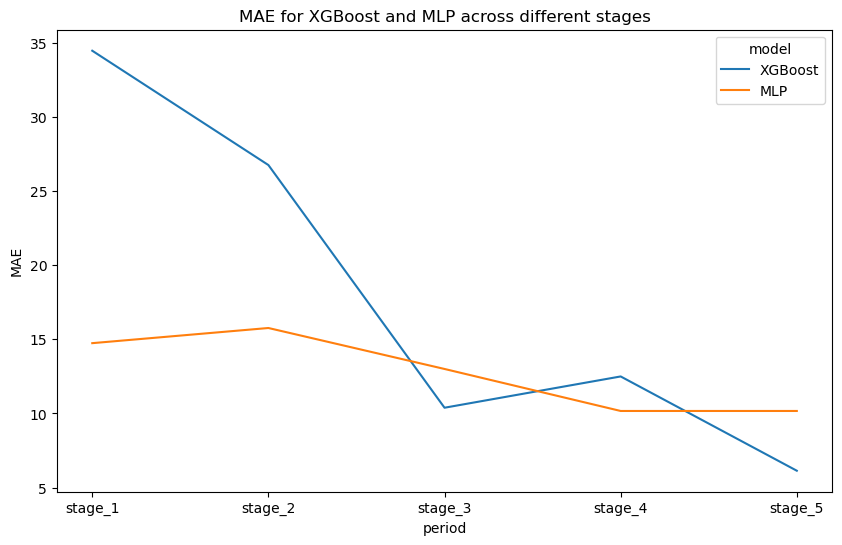

In [80]:
import pandas as pd

data = {
    'period': ['stage_1', 'stage_2', 'stage_3', 'stage_4', 'stage_5', 'stage_1', 'stage_2', 'stage_3', 'stage_4', 'stage_5'],
    'model': ['XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP'],
    'MAE': [34.483, 26.767, 10.387, 12.498, 6.135, 14.745, 15.768, 13.003, 10.168, 10.168]
}

df = pd.DataFrame(data)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='period', y='MAE', hue='model')
plt.title('MAE for XGBoost and MLP across different stages')
plt.show()


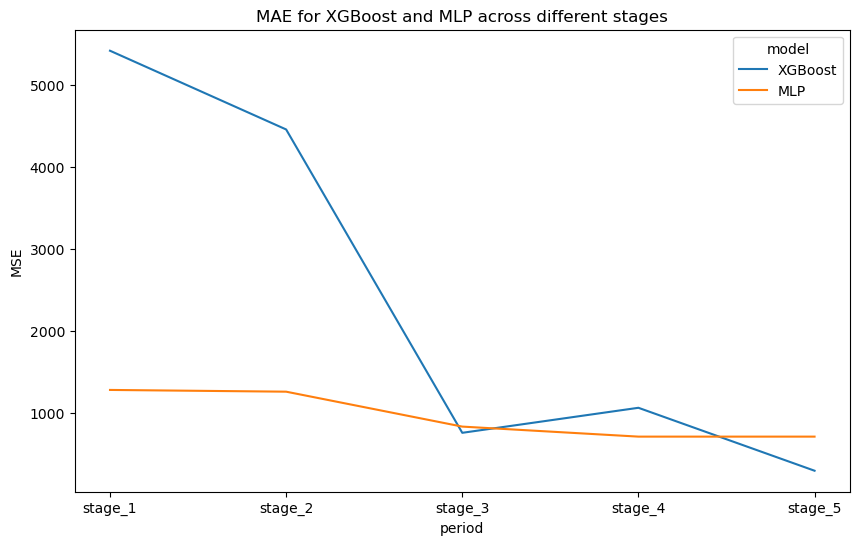

In [86]:
import pandas as pd

data = {
    'period': ['stage_1', 'stage_2', 'stage_3', 'stage_4', 'stage_5', 'stage_1', 'stage_2', 'stage_3', 'stage_4', 'stage_5'],
    'model': ['XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'MLP', 'MLP', 'MLP', 'MLP', 'MLP'],
#     'MAE': [34.483, 26.767, 10.387, 12.498, 6.135, 14.745, 15.768, 13.003, 10.168, 10.168]
    'MSE': [5413.818, 4455.451, 763.111, 1067.678, 301.660, 1284.971, 1263.745, 838.720, 716.696, 716.696]
}

df = pd.DataFrame(data)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='period', y='MSE', hue='model')
plt.title('MAE for XGBoost and MLP across different stages')
plt.show()
